In [30]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [31]:
# Arguments
args = Namespace(
    seed=1234,
    data_file="sample_data.csv",
    num_samples=100,
    train_size=0.75,
    test_size=0.25,
    num_epochs=100,
)

# Set seed for reproducability
np.random.seed(args.seed)

In [32]:
# Generate synthetic data
def generate_data(num_samples):
    X = np.array(range(num_samples))
    y = 3.65*X + 10
    return X, y

In [33]:
# Generate random (linear) data
X, y = generate_data(args.num_samples)
data = np.vstack([X, y]).T
df = pd.DataFrame(data, columns=['X', 'y'])
df.head()

,X,y
0,0.0,10.00
1,1.0,13.65
2,2.0,17.30
3,3.0,20.95
4,4.0,24.60


In [41]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./competitive-data-science-predict-future-sales"))

['.DS_Store', 'sales_train.csv', 'shops.csv', 'test.csv', 'item_categories.csv', 'items.csv', 'sample_submission.csv']


In [42]:
sales = pd.read_csv("./competitive-data-science-predict-future-sales/sales_train.csv")

In [43]:
import datetime
sales.date = sales.date.apply(lambda x:datetime.datetime.strptime(x, "%d.%m.%Y"))
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [44]:
for i in range(4, 10):
    sales["lag_{}".format(i)] = sales.item_cnt_day.shift(i)
print("done")

done


In [45]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
0,2013-01-02,0,59,22154,999.00,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-03,0,25,2552,899.00,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-05,0,25,2552,899.00,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-06,0,25,2554,1709.05,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-15,0,25,2555,1099.00,1.0,1.0,NaN,NaN,NaN,NaN,NaN


In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
"""plt.figure(figsize=(16,8))
sns.lineplot(x=sales.date, y=sales.item_cnt_day)"""

'plt.figure(figsize=(16,8))\nsns.lineplot(x=sales.date, y=sales.item_cnt_day)'

In [47]:
X = sales.dropna().drop(["item_cnt_day", "item_price", "date_block_num"], axis=1)

In [48]:
X = X.iloc[:,1:]
X = X.reset_index(drop=True)

In [49]:
X.head()

,shop_id,item_id,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
0,25,2573,1.0,1.0,1.0,-1.0,1.0,1.0
1,25,2574,1.0,1.0,1.0,1.0,-1.0,1.0
2,25,2574,1.0,1.0,1.0,1.0,1.0,-1.0
3,25,2574,1.0,1.0,1.0,1.0,1.0,1.0
4,25,2574,3.0,1.0,1.0,1.0,1.0,1.0


In [50]:
y = sales.dropna().item_cnt_day

In [51]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X = sc_x.fit_transform(X)
X = pd.DataFrame(X)

In [52]:
def TimeSeriesTrainTestSplit(x, y, test_size):
    
        test_index = int(len(X)*(1-test_size))
    
        X_train = X.iloc[:test_index]
        y_train = y.iloc[:test_index]
        X_test = X.iloc[test_index:]
        y_test = y.iloc[test_index:]
        return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = TimeSeriesTrainTestSplit(X,y, 0.2)

In [53]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [54]:
from sklearn.model_selection import TimeSeriesSplit
ts_cross_val = TimeSeriesSplit(n_splits=5)

In [55]:
from sklearn.model_selection import cross_val_score
cv = cross_val_score(regressor, X_train, y_train, cv = ts_cross_val, scoring= "neg_mean_squared_error")

In [56]:
cv

array([-1.62977634, -5.52271258, -2.37611148, -4.31103126, -9.9849925 ])

In [57]:
y_pred = regressor.predict(X_test)

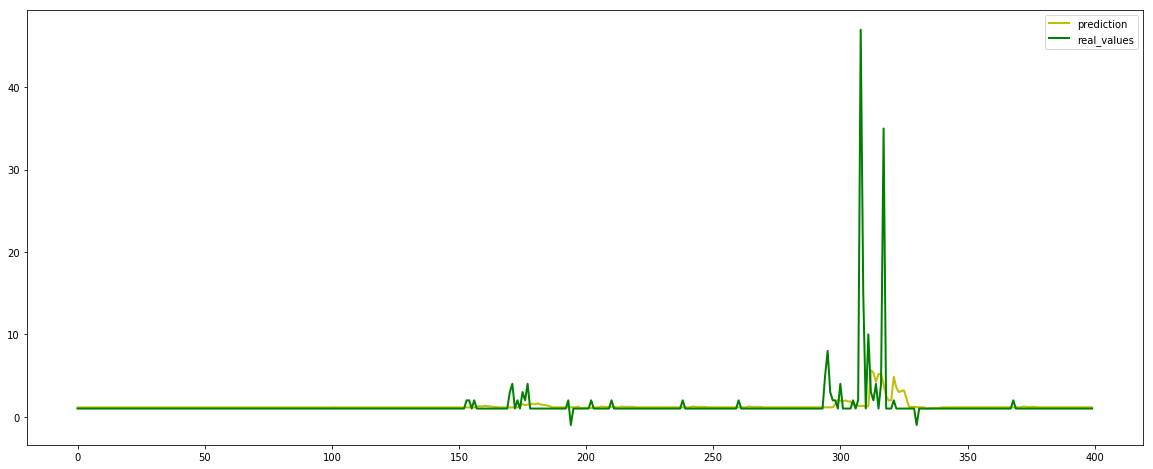

In [58]:
plt.figure(figsize=(20,8))
plt.plot(regressor.predict(X_test[-400:]), "y", label="prediction", linewidth=2.0)
plt.plot(y_test.values[-400:], "g", label="real_values", linewidth=2.0)
plt.legend(loc="best")

In [60]:
test = pd.read_csv("./competitive-data-science-predict-future-sales/test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


In [61]:
test = test.merge(sales, how="left", on = ["shop_id", "item_id"], copy=False)
test = test.drop_duplicates()


In [62]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1327233 entries, 0 to 1327234
Data columns (total 13 columns):
ID                1327233 non-null int64
shop_id           1327233 non-null int64
item_id           1327233 non-null int64
date              1224437 non-null datetime64[ns]
date_block_num    1224437 non-null float64
item_price        1224437 non-null float64
item_cnt_day      1224437 non-null float64
lag_4             1224436 non-null float64
lag_5             1224436 non-null float64
lag_6             1224436 non-null float64
lag_7             1224436 non-null float64
lag_8             1224436 non-null float64
lag_9             1224436 non-null float64
dtypes: datetime64[ns](1), float64(9), int64(3)
memory usage: 141.8 MB


In [63]:
test.drop(["ID", "date", "date_block_num", "item_cnt_day", "item_price"], axis=1, inplace=True)

In [64]:
test = test.dropna()

In [65]:
y_pred = regressor.predict(test)
print(y_pred)

[165.4365791  165.4365791  165.4365791  ...  33.14823932  33.36629838
  33.14823932]


In [66]:
submission = pd.DataFrame(y_pred)
print(submission)

                  0
0        165.436579
1        165.436579
2        165.436579
3        165.436579
4        165.436579
5        165.436579
6        165.436579
7        165.436579
8        165.436579
9        165.436579
10       165.436579
11       165.436579
12       165.436579
13       171.792691
14       171.792691
15       171.792691
16       171.792691
17       171.792691
18       171.792691
19       171.792691
20       171.792691
21       171.792691
22       171.760262
23       165.909165
24       165.782420
25       165.580250
26       165.501437
27       165.501437
28       165.501437
29       165.501437
...             ...
1224406  143.263756
1224407  142.856029
1224408  142.856029
1224409  142.856029
1224410  142.856029
1224411  143.013351
1224412  142.856029
1224413  587.037994
1224414  587.195317
1224415  587.037994
1224416  600.171797
1224417  600.171797
1224418  600.171797
1224419  600.171797
1224420  600.171797
1224421  600.171797
1224422  600.171797
1224423  600.171797


In [67]:
submission = submission.dropna()
submission.rename(columns={"index":"ID", 0:"item_cnt_month"})
submission = submission.iloc[:214201,:]